# Harry Potter Review Analysis

https://www.kaggle.com/datasets/marcpaulo/harry-potter-reviews/data

In [22]:
!pip3 install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 866.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=3d160c0ab3d5e40ae338ffec49b31f9269a95248ce2e8dfad2ea8c00b0ee9ae2
  Stored in directory: /root/.cache/pip/wheels/1b/bd/d9/310c33c45a553798a714e27e3b8395d37128425442b8c78e07
Successfully built emoji


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, platform
import emoji

%matplotlib inline

## Read kaggle DataSet

In [4]:
data_ini = pd.read_csv("/content/harry_potter_reviews.csv", sep=",")

In [ ]:
data_ini.head()

,user_id,user_sex,user_age,user_country,rating,comment,favourite_character,date
0,0,female,50,Germany,2.5,"""The transitions between scenes were awkward, ...",Severus Snape,2004-12-27
1,1,female,23,Spain,4.0,"""Severus Snape's role adds an intriguing layer.""",Severus Snape,2003-11-22
2,2,male,32,France,3.0,"""The pacing was a bit slow, but the characters...",Ron Weasley,2005-09-16
3,3,female,24,Turkey,4.5,"""Hagrid's love for magical creatures is heartw...",Rubeus Hagrid,2002-09-17
4,4,female,40,Spain,5.0,"""Neville Longbottom's courage is awe-inspiring.""",Neville Longbottom,2004-10-17


In [5]:
data_ini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              491 non-null    int64  
 1   user_sex             491 non-null    object 
 2   user_age             491 non-null    int64  
 3   user_country         491 non-null    object 
 4   rating               491 non-null    float64
 5   comment              491 non-null    object 
 6   favourite_character  491 non-null    object 
 7   date                 491 non-null    object 
dtypes: float64(1), int64(2), object(5)
memory usage: 30.8+ KB


In [6]:
data_ini.shape

(491, 8)

In [7]:
data_ini.columns

Index(['user_id', 'user_sex', 'user_age', 'user_country', 'rating', 'comment',
       'favourite_character', 'date'],
      dtype='object')

In [8]:
data_ini.isna().sum()

user_id                0
user_sex               0
user_age               0
user_country           0
rating                 0
comment                0
favourite_character    0
date                   0
dtype: int64

## Data Preparation

In [36]:
# Rmove user_id
data = data_ini.drop("user_id", axis=1)

In [10]:
data.head()

,user_sex,user_age,user_country,rating,comment,favourite_character,date
0,female,50,Germany,2.5,"""The transitions between scenes were awkward, ...",Severus Snape,2004-12-27
1,female,23,Spain,4.0,"""Severus Snape's role adds an intriguing layer.""",Severus Snape,2003-11-22
2,male,32,France,3.0,"""The pacing was a bit slow, but the characters...",Ron Weasley,2005-09-16
3,female,24,Turkey,4.5,"""Hagrid's love for magical creatures is heartw...",Rubeus Hagrid,2002-09-17
4,female,40,Spain,5.0,"""Neville Longbottom's courage is awe-inspiring.""",Neville Longbottom,2004-10-17


In [37]:
# transform date column to datetime format

data['date'] = pd.to_datetime(data['date'])

## Do some fancy statistics and Plots

In [12]:
data.describe()

,user_age,rating
count,491.000000,491.000000
mean,35.274949,3.979633
std,11.231868,0.945771
min,8.000000,1.500000
25%,28.000000,3.500000
50%,35.000000,4.500000
75%,43.000000,4.500000
max,64.000000,5.000000


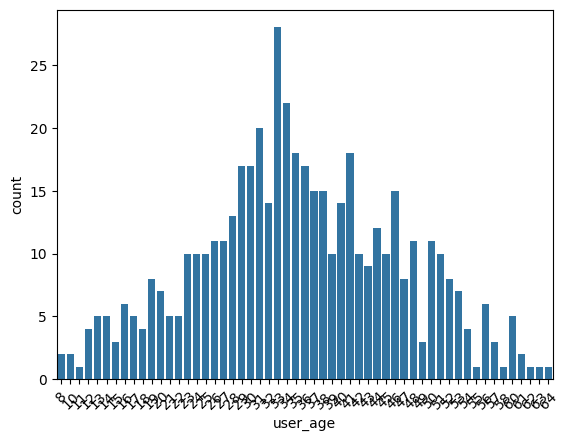

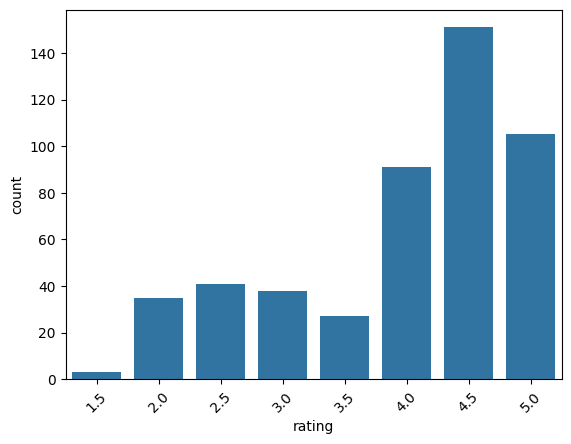

In [13]:
# numerical columns: histograms for each col (user_age, rating, date)
numerical_cols =["user_age", "rating"]

for col in numerical_cols:
    plt.figure()
    sns.countplot(data, x=col)
    plt.tick_params(axis='x', labelrotation=45)

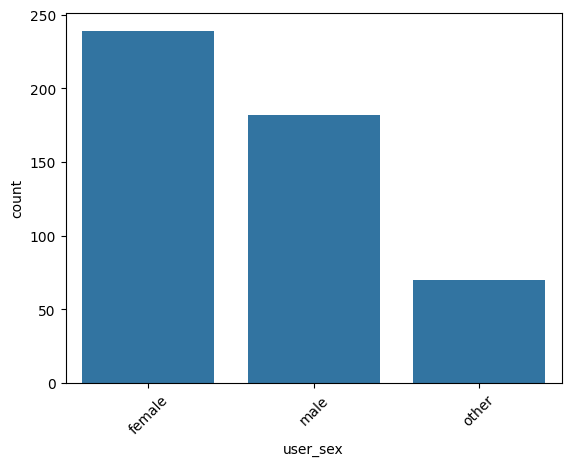

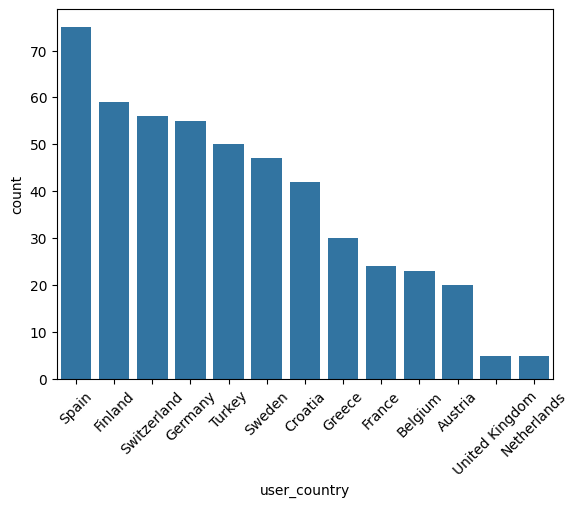

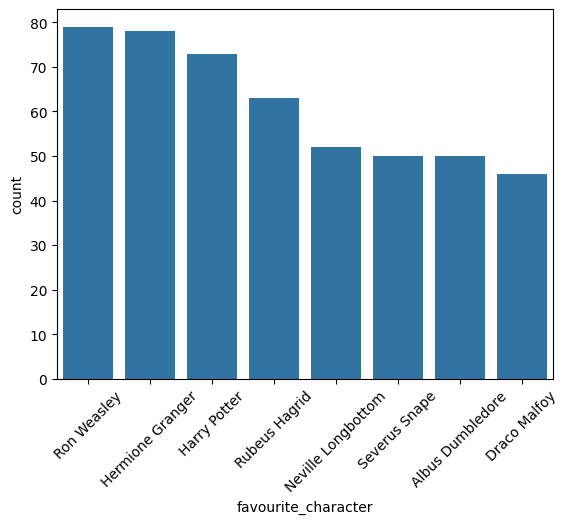

In [14]:
# categorical columns: country, user_sex, favorite character, barplot sorted
categorical_cols = ["user_sex", "user_country", "favourite_character"]

for col in categorical_cols:
    plt.figure()
    sns.countplot(data, x=col, order = data[col].value_counts().index)
    plt.tick_params(axis='x', labelrotation=45)

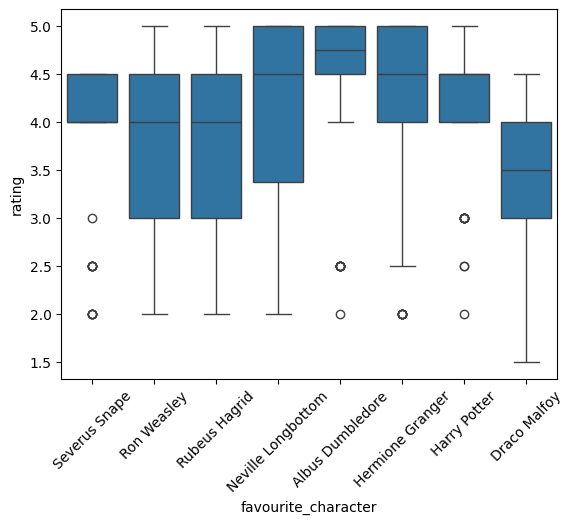

In [15]:
# boxplot to show rating for each favorite character
sns.boxplot(data=data, x="favourite_character", y="rating")
plt.tick_params(axis='x', labelrotation=45)

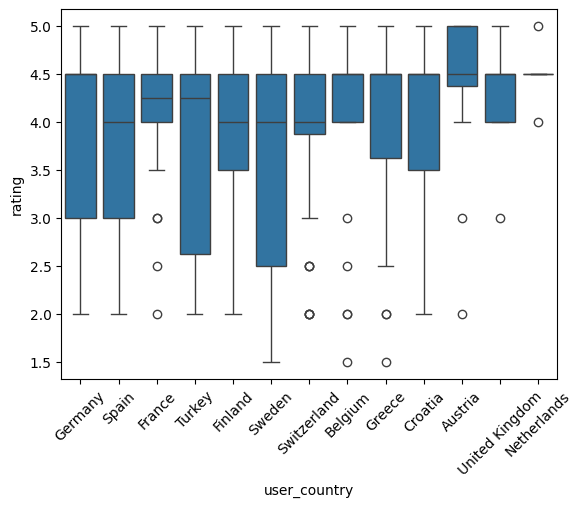

In [16]:
# boxplot to show rating for each country
sns.boxplot(data=data, x="user_country", y="rating")
plt.tick_params(axis='x', labelrotation=45)

In [18]:
data.groupby("user_country").count()["rating"].sort_values()

user_country
Netherlands        5
United Kingdom     5
Austria           20
Belgium           23
France            24
Greece            30
Croatia           42
Sweden            47
Turkey            50
Germany           55
Switzerland       56
Finland           59
Spain             75
Name: rating, dtype: int64

## Use text classification to evaluate reviews

In [28]:
def print_system_specs():
    # Check if CUDA is available
    is_cuda_available = torch.cuda.is_available()
    print("CUDA Available:", is_cuda_available)
# Get the number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print("Number of CUDA devices:", num_cuda_devices)
    if is_cuda_available:
        for i in range(num_cuda_devices):
            # Get CUDA device properties
            device = torch.device('cuda', i)
            print(f"--- CUDA Device {i} ---")
            print("Name:", torch.cuda.get_device_name(i))
            print("Compute Capability:", torch.cuda.get_device_capability(i))
            print("Total Memory:", torch.cuda.get_device_properties(i).total_memory, "bytes")
    # Get CPU information
    print("--- CPU Information ---")
    print("Processor:", platform.processor())
    print("System:", platform.system(), platform.release())
    print("Python Version:", platform.python_version())
print_system_specs()

CUDA Available: False
Number of CUDA devices: 0
--- CPU Information ---
Processor: x86_64
System: Linux 6.1.58+
Python Version: 3.10.12


In [31]:
# Load model directly
model_name = 'finiteautomata/bertweet-base-sentiment-analysis'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization=True)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [40]:
data.iat[0, 4]

'"The transitions between scenes were awkward, and the soundtrack was forgettable."'

In [41]:
# Sample data
test = data.iat[0, 4]
# Perform sentiment analysis
results = classifier(test)
print(results)

[{'label': 'NEG', 'score': 0.9579859972000122}]


In [58]:
def apply_model(review):

    result = classifier(review)
    label = result[0]["label"]
    #score = result[0]["score"]

    return label



In [59]:
data['label'] = data["comment"].apply(apply_model)

In [60]:
data.head()

,user_sex,user_age,user_country,rating,comment,favourite_character,date,label
0,female,50,Germany,2.5,"""The transitions between scenes were awkward, ...",Severus Snape,2004-12-27,NEG
1,female,23,Spain,4.0,"""Severus Snape's role adds an intriguing layer.""",Severus Snape,2003-11-22,POS
2,male,32,France,3.0,"""The pacing was a bit slow, but the characters...",Ron Weasley,2005-09-16,POS
3,female,24,Turkey,4.5,"""Hagrid's love for magical creatures is heartw...",Rubeus Hagrid,2002-09-17,POS
4,female,40,Spain,5.0,"""Neville Longbottom's courage is awe-inspiring.""",Neville Longbottom,2004-10-17,POS


In [61]:
data.groupby("label").count()["comment"]

label
NEG    109
NEU     32
POS    350
Name: comment, dtype: int64

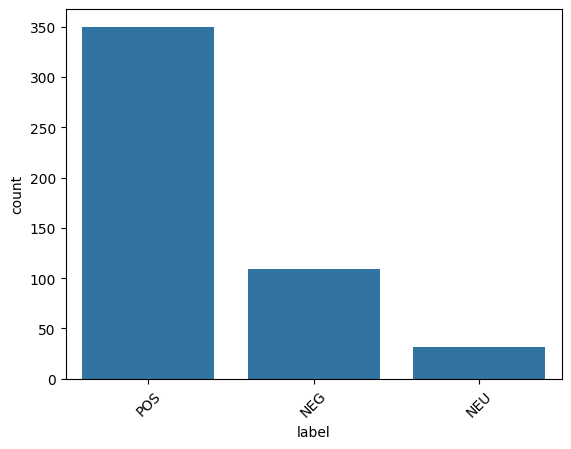

In [72]:
plt.figure()
sns.countplot(data, x="label",
              order = data["label"].value_counts().index)
plt.tick_params(axis='x', labelrotation=45)


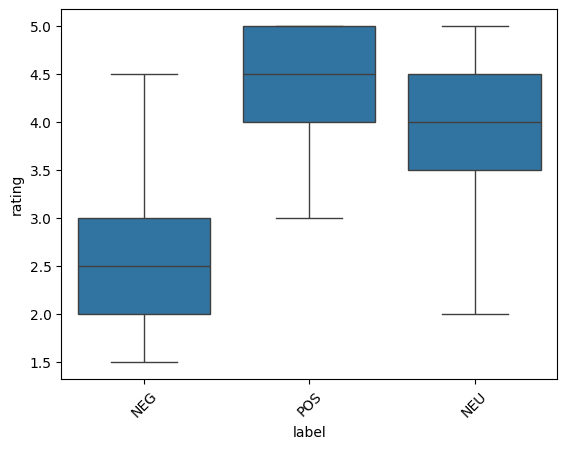

In [70]:
sns.boxplot(data=data, x="label", y="rating")
plt.tick_params(axis='x', labelrotation=45)

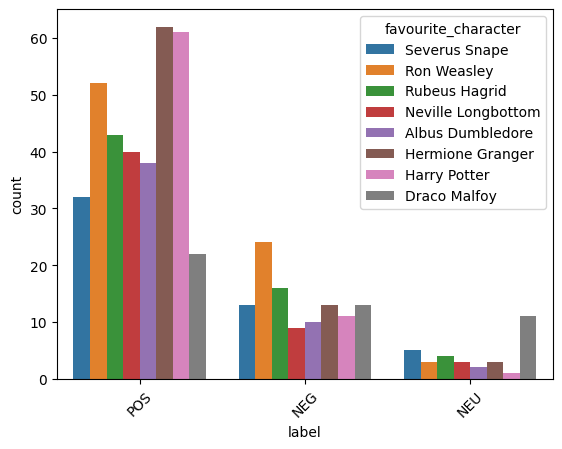

In [74]:
plt.figure()
sns.countplot(data, x="label",
              order = data["label"].value_counts().index, hue="favourite_character")
plt.tick_params(axis='x', labelrotation=45)